In [2]:
import subprocess
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import io
from pydub import AudioSegment

In [36]:
# main path
current_dir = '/home/ivan/Рабочий стол/ПЛАН/telegram_bot_test' # locating script folder
file_name_csv = 'telebot_db.csv'
file_path_csv = os.path.join(current_dir,file_name_csv)
file_name_dump = 'telebot_db.dump'
file_path_dump = os.path.join(current_dir,file_name_dump)

# Viewing storaged data (from file .csv)

In [38]:
df_storage=pd.read_csv(file_path_csv,sep='|',engine='python')
df_storage.head()

,first_name,last_name,is_bot,update_id,message_id,date,chat_id,text_message,file_id,content_file,type_message,description
0,Иван,Надин,False,372935418,406,2020-07-31 06:18:32,516449722,68656c6c6f,NaN,NaN,0,text_message
1,Иван,Надин,False,372935416,402,2020-07-31 06:16:36,516449722,68656c6c6f,AgACAgIAAxkBAAIBkl8jt0T5Ex0PjV2Q0jsZN6a6-OyrAA...,ffd8ffe000104a46494600010101006000600000ffdb00...,1,photo_message
2,Иван,Надин,False,372935415,400,2020-07-31 06:16:30,516449722,NaN,AgACAgIAAxkBAAIBkF8jtz6Upqo46yCmhcG4lVfOiAkTAA...,ffd8ffe000104a46494600010101006000600000ffdb00...,1,photo_message
3,Иван,Надин,False,372935414,398,2020-07-31 06:15:54,516449722,NaN,AwACAgIAAxkBAAIBjl8jtxrOmXIrKsGX_-GwD6S4inzuAA...,4f67675300020000000000000000e298db7100000000a0...,2,voice_message


In [40]:
# viewing input text_message
for text  in df_storage[~df_storage['text_message'].isnull()]['text_message']:
    print(bytes.fromhex(text).decode("utf-8"))

hello
hello


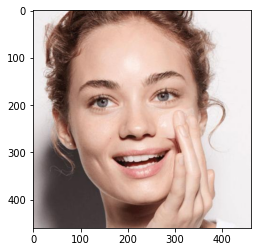

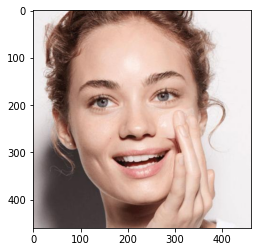

In [42]:
# viewing input photo_message
for photo  in df_storage.loc[df_storage['type_message']==1]['content_file']:
    image_bytes=bytes.fromhex(photo)
    img = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(im_rgb)
    plt.show()

In [43]:
# viewing voice message
for voice  in df.loc[df['type_message']==2]['content_file']:
    voice_bytearray=bytearray.fromhex(voice)
    voice_bytes = io.BytesIO(voice_bytearray)
    audio=AudioSegment.from_file(voice_bytes)
    
    #audio = audio.set_frame_rate(16000) 
    #audio.export('test_voice',format="wav")
audio

# Work with bot database

In [46]:
# variables for connection
db_user='postgres'
db_password='1'
db_name='telebot_db'
db_host='localhost'
db_port='5432'
db_telebot='telebot_db'# telegram bot database 
db_dump_name='telebot_db_dump'# database for import dump file


## Receiving  data from bot's database

In [44]:
sql_telebot_db="""
    select
         ci.first_name
        ,ci.last_name
        ,ci.is_bot
        ,ui.update_id
        ,ui.message_id
        ,ui.date
        ,ui.chat_id
        ,encode(uf.text_message::bytea, 'hex') as text_message -- convert to hex
        ,uf.file_id
        ,encode(uf.content_file::bytea, 'hex') as content_file -- convert to hex
        ,uf.type_message
        ,tf.description

    from update_info ui
    
        inner join update_files uf
           on ui.update_id=uf.update_id
        inner join chat_info ci
           on ci.chat_id=ui.chat_id
        inner join description_type_message tf
           on tf.type_message=uf.type_message      
         """

In [47]:
#conecting to dump_file database
try:
    conn = psycopg2.connect   (user = db_user,
                              password = db_password,
                              host = db_host,
                              port = db_port,
                              database = db_telebot)
    conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
    print(f'Successfully conected to database {db_telebot}')
    
    df=pd.read_sql(sql_telebot_db,conn) # get data from database
    
except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
finally:
    conn.close()

Successfully conected to database telebot_db


In [48]:
df.head()

,first_name,last_name,is_bot,update_id,message_id,date,chat_id,text_message,file_id,content_file,type_message,description
0,Иван,Надин,False,372935418,406,2020-07-31 06:18:32,516449722,68656c6c6f,None,None,0,text_message
1,Иван,Надин,False,372935416,402,2020-07-31 06:16:36,516449722,68656c6c6f,AgACAgIAAxkBAAIBkl8jt0T5Ex0PjV2Q0jsZN6a6-OyrAA...,ffd8ffe000104a46494600010101006000600000ffdb00...,1,photo_message
2,Иван,Надин,False,372935415,400,2020-07-31 06:16:30,516449722,None,AgACAgIAAxkBAAIBkF8jtz6Upqo46yCmhcG4lVfOiAkTAA...,ffd8ffe000104a46494600010101006000600000ffdb00...,1,photo_message
3,Иван,Надин,False,372935414,398,2020-07-31 06:15:54,516449722,None,AwACAgIAAxkBAAIBjl8jtxrOmXIrKsGX_-GwD6S4inzuAA...,4f67675300020000000000000000e298db7100000000a0...,2,voice_message


In [49]:
df.to_csv(file_path_csv,sep='|',index=None) # save to file

## Export database 

In [53]:
subprocess.Popen(
                f"pg_dump --dbname=postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_telebot} > '{file_path_dump}'"
                ,shell=True
                )# unsecure method
# subprocess return empty file , one of the possible reasons is pg_dump is not on your PATH, 
#then replace "pd_dump" on "/usr/bin/pg_dump" (command "which pd_dump" show path of pg_dump )

In [ ]:
#another variant with console  (without Python)
#https://www.digitalocean.com/community/tutorials/how-to-backup-postgresql-databases-on-an-ubuntu-vps

#1. sudo su postgres 
#2. pg_dump -U postgres  telebot_db > dump_name.sql | where postgres - user , telebot_db- database_name
# file location in  /var/lib/postgresql (for Linux)

## Import database 

In [52]:
#t o import a dump file,  need to create a database for it in advance
try: 
    #conecting to existing database
    conn = psycopg2.connect   (user = db_user, 
                              password = db_password,
                              host = db_host,
                              port = db_port,
                              database = db_telebot)
    conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
    print(f'Successfully conected to database {db_telebot}')
    
    cursor=conn.cursor()
    cursor.execute(f'CREATE DATABASE {db_dump_name}')
    cursor.close()
    print ("Successfully created  database {db_dump_name} ")
    
except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
finally:
    conn.close()

Successfully conected to database telebot_db
Successfully created  database 


In [54]:
# import dump file in previously created database
command=f"psql --dbname=postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_dump_name} < '{file_path_dump}'"
subprocess.Popen(command,shell=True)

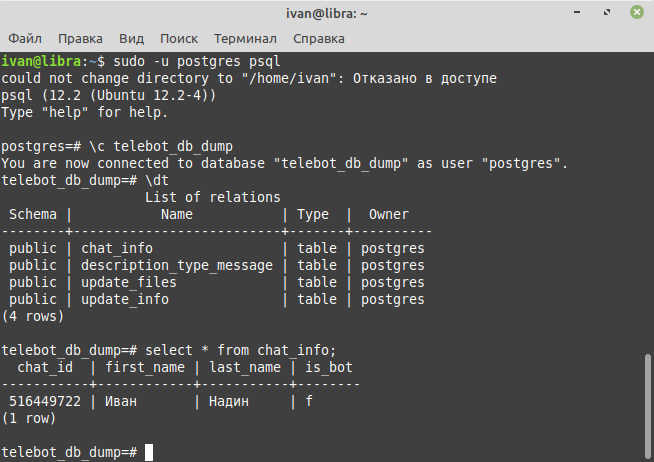

In [55]:
# checking new database
from IPython.display import Image
Image(filename='check_dump.png')